In [1]:
import json
import jsonschema
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import os

In [2]:
files = os.scandir("data/deaths_hu")
file_names = []
for file in files:
    if file.name != "latest.json" and file.name[-5:] == ".json":
        file_names.append(file.name)
file_names.sort()

In [3]:
def json2df(filename):
    df = pd.read_json("data/deaths_hu/{}".format(filename)).dropna()
    df["Sorszám"] = df["Sorszám"].astype(int)
    df["Kor"].replace('', None, inplace=True)
    df["Kor"] = df["Kor"].astype(int)
    df["date"] = pd.to_datetime(filename[0:10], format='%Y-%m-%d')
    return df.set_index(["Sorszám", "Nem", "Kor"])

def join(df1, df2):
    df3 = df1.join(df2, lsuffix="_left", rsuffix="_right", how='outer')
    df3["date"] = df3.apply(lambda row: find_first_val(row, "date", "date"), axis=1)
    df3["Alapbetegségek"] = df3.apply(lambda row: find_first_val(row, "date", "Alapbetegségek"), axis=1)
    # df3[df3["Alapbetegségek_left"]!=df3["Alapbetegségek_right"]]
    return df3[["date", "Alapbetegségek"]]

def find_first_val(row, date_col, val_col):
    if pd.isnull(row["{}_left".format(date_col)]):
        return row["{}_right".format(val_col)]
    else:
        return row["{}_left".format(val_col)]

In [4]:
df0 = json2df(file_names[0])
for key in range(1, len(file_names)):
    df1 = json2df(file_names[key])
    df0 = join(df0, df1)

In [5]:
df = df0.reset_index()
df[df["Kor"]<60].tail(10)

,Sorszám,Nem,Kor,date,Alapbetegségek
7494,7458,férfi,52,2020-12-17,magasvérnyomás-betegség
7501,7465,férfi,39,2020-12-17,"veseelégtelenség, magasvérnyomás betegség"
7507,7471,férfi,59,2020-12-17,agysorvadás
7511,7475,férfi,53,2020-12-17,"vérzékenység, veseelégtelenség"
7528,7492,férfi,59,2020-12-17,magasvérnyomás-betegség
7540,7504,férfi,53,2020-12-17,"vérmérgezés, vérszegésnység"
7541,7505,nõ,48,2020-12-17,adat feltöltés alatt
7562,7526,nõ,52,2020-12-17,"magasvérnyomás-betegség, májbetegség"
7566,7530,férfi,57,2020-12-17,daganatos megbetegedés
7572,7536,nõ,57,2020-12-17,mentális retardáció


In [6]:
df["Kor_class"] = df["Kor"].apply(lambda cell: cell - (cell % 10))
df["week"] = df["date"].dt.week + df["date"].dt.year * 100
df["day"] = df["date"] - pd.to_timedelta(df['date'].dt.dayofweek, unit="D")
df_group = df.groupby(["day", "Kor_class"]).agg({"Nem":"count"}).reset_index()

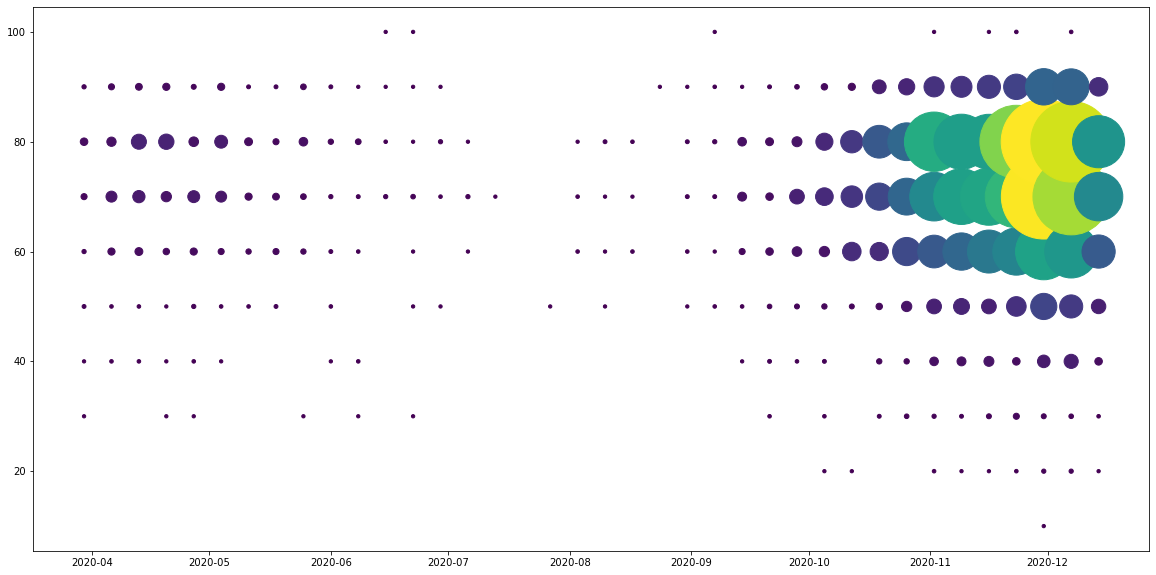

In [7]:
plt.subplots(figsize=(20,10))
plt.scatter(x=df_group["day"], y=df_group["Kor_class"], s=10+df_group["Nem"]**1.5, c=df_group["Nem"])
plt.show()

In [17]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
base_dir = os.path.join("/home/jovyan/work/Corona/COVID-19")
sys.path.append(base_dir)
import model as md

In [18]:
merger = md.Merger(data_dir="data", load_from_raw=False, load_from_agg=True)
df = merger.merge_deaths_df()

In [19]:
df["Kor_class"] = df["Kor"].apply(lambda cell: cell - (cell % 10), meta=('Kor', 'int64'))
df["week"] = df["date"].dt.week + df["date"].dt.year * 100
df["day"] = df["date"].apply(lambda cell: cell - pd.to_timedelta(cell.dt.dayofweek, unit="D"))
#df["day"] = df["date"] - pd.to_timedelta(df['date'].dt.dayofweek, unit="D")
#df_group = df.groupby(["day", "Kor_class"]).agg({"Nem":"count"}).reset_index()
df.head()

ValueError: Metadata inference failed in `apply`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
AttributeError("'Timestamp' object has no attribute 'dt'")

Traceback:
---------
  File "/opt/conda/lib/python3.7/site-packages/dask/dataframe/utils.py", line 172, in raise_on_meta_error
    yield
  File "/opt/conda/lib/python3.7/site-packages/dask/dataframe/core.py", line 4999, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
  File "/opt/conda/lib/python3.7/site-packages/dask/utils.py", line 894, in __call__
    return getattr(obj, self.method)(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/series.py", line 3848, in apply
    mapped = lib.map_infer(values, f, convert=convert_dtype)
  File "pandas/_libs/lib.pyx", line 2329, in pandas._libs.lib.map_infer
  File "<ipython-input-19-662d0fabe23a>", line 3, in <lambda>
    df["day"] = df["date"].apply(lambda cell: cell - pd.to_timedelta(cell.dt.dayofweek, unit="D"))


In [ ]:
plt.subplots(figsize=(20,10))
plt.scatter(x=df_group["day"], y=df_group["Kor_class"], s=10+df_group["Nem"]**1.5, c=df_group["Nem"])
plt.show()